In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Context Aware Sensitive Data Detection using LangChain + Vertex AI PaLM API

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/language/use-cases/sensitive-data-detection/context_aware_sensitive_data_detection.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/use-cases/sensitive-data-detection/context_aware_sensitive_data_detection.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/language/use-cases/sensitive-data-detection/context_aware_sensitive_data_detection.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

This notebook demonstrates Generative AI's ability to detect sensitive information in unstructured data such as call or chat transcripts. This is a task that is often challenging for conventional pattern-recognition methods due to the following factors:

*   Lack of consistency in verbal communications: People speak in a variety of ways, and it can be difficult for computers to understand all of the nuances of human speech.
*   Speech-to-text inaccuracies: Speech-to-text software is not always accurate, and this can lead to errors in the data that is being analyzed.
*   Natural language variations: The way that people use language can vary depending on their culture, their education, and their profession. This can make it difficult for computers to understand the meaning of certain words or phrases.
*   Need for contextual understanding: In order to accurately detect sensitive information, computers need to understand the context in which the information is being communicated. This can be difficult, especially if the information is being communicated in a casual or informal setting.


### Approach

Generative AI models offer a significant advantage over pattern-based identification methods for sensitive data detection because they are designed to understand and generate human-like text based on context. This deep understanding of language and context allows them to infer the semantics of a sentence, thereby distinguishing sensitive data from similar non-sensitive information within the given context. For instance, they can recognize when a series of digits represents a phone number versus non-sensitive numeric data based on how it is used in a sentence.

By understanding the broader context and recognizing subtle nuances, generative AI models can significantly enhance the accuracy and efficiency of sensitive data detection.


Below architecture diagram shows a high level overview about this approach.


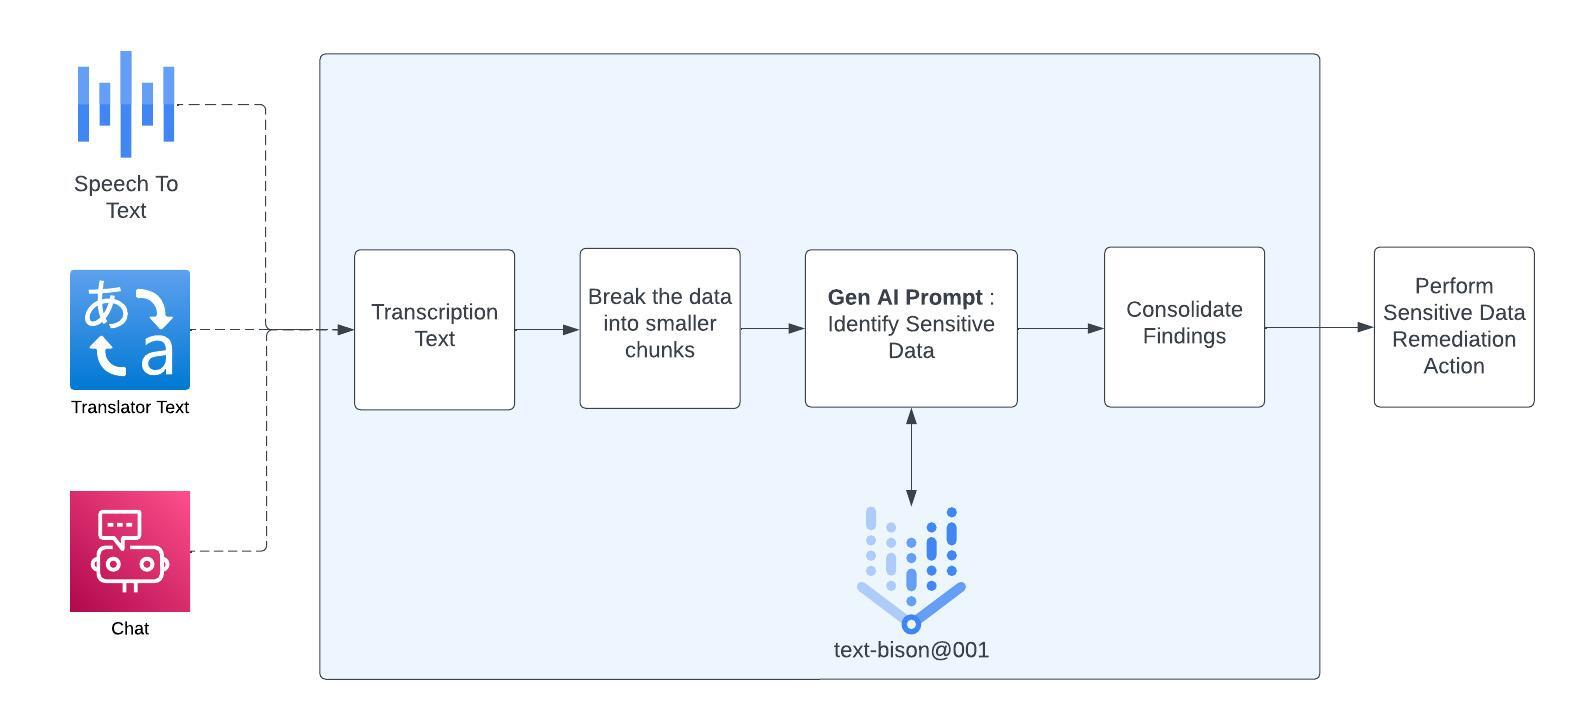

## Getting Started

### Install libraries

In [ ]:
# Install required packages
! pip install google-cloud-aiplatform langchain tiktoken --upgrade --user

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

## Import Libraries

In [ ]:
from collections import defaultdict
from typing import List, Optional

import inflect
import vertexai
from langchain.chains import LLMChain
from langchain.llms import VertexAI
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.text_splitter import CharacterTextSplitter
from pydantic import BaseModel

## Initialize Model

In [ ]:
PROJECT_ID = "YOUR_PROJECT_ID"  # @param {type:"string"}
LOCATION = "us-central1"        # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
model_name = "text-bison@001"  # @param {type:"string"}
llm = VertexAI(
    model_name=model_name,
    max_output_tokens=1024,
    temperature=0,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

## Generate Sample Text with Sensitive Data

Note: `sample_sensitive_text` can be replaced with any unstructured data to be used as input for this excercise

In [ ]:
sample_sensitive_text = llm(
    """
Generate a support call transcript between agent and a customer which requires sharing of all the following actual customer's details mobile number,office number,   address, date of birth, travel document number.
Display the mobile numbers in numeric words i.e nine one six two seven three double one.
Display the address in two different lines.
Display the date of birth in a speech format.
"""
)
print(sample_sensitive_text)

Handle large input files by breaking them into smaller chunks

In [ ]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1024, chunk_overlap=0
)
texts = text_splitter.split_text(sample_sensitive_text)

## Output Parsers

Output Parsers help to format the output of a model. Usually used for structured output.

Define Pydanitc Base model with all the sensitive data types that needs to be identified in the given input text.

This is required to parse the Gen AI output to make sure we dont get erroneous results

In [ ]:
class SensitiveDataModelList(BaseModel):
    EMAIL_ADDRESS: Optional[List[str]] = None
    PHONE_NUMBER: Optional[List[str]] = None
    PASSPORT: Optional[List[str]] = None
    LOCATION: Optional[List[str]] = None
    PASSWORD: Optional[List[str]] = None
    PERSON_NAME: Optional[List[str]] = None
    DATE_OF_BIRTH: Optional[List[str]] = None
    # Add any other info type that needs to be identified in the given text


parser = PydanticOutputParser(pydantic_object=SensitiveDataModelList)

## Prompt Template

Prompt is injected with the type of sensitive data to be identified in the given text i.e pii_type, expected json output response format i.e format_instruction and the actual input i.e sample_sensitive_text broken down into smaller chunks

In [ ]:
pii_type = ", ".join(
    [
        inflect.engine().plural(word)
        for word in SensitiveDataModelList.__annotations__.keys()
    ]
)

format_instruction = parser.get_format_instructions

prompt_template = """ Identify  all the  {pii_type} data available in the input  and in JSON format.  If no data found for any of the type return as NONE. \n Input : {pii_data}  \n{format_instructions}.
    ###Examples###
    Input :  Hi, i name is jegadesh. My phone number is  nine one six one seven two double one and date of birth is september 20 in 2023. my another phone number is 9789516267. My address is siglap centre, singapore 455982
    Output : {{"PHONE_NUMBER": ["nine one six one seven two double one","9789516267"], "DATE_OF_BIRTH": ["september 20 in 2023"], "PERSON_NAME": ["jegadesh"],  "LOCATION": [" siglap centre, singapore 455982"}}

  """

prompt = PromptTemplate(
    input_variables=["pii_type", "pii_data"],
    template=prompt_template,
    output_parser=parser,
    partial_variables={"format_instructions": parser.get_format_instructions},
)

## Execute Model Chain on Input Text

Create a simple LLMChain with the define prompt and llm model

In [ ]:
chain = LLMChain(llm=llm, prompt=prompt)

Iterate over each chunk of the input data i.e `sample_sensitive_text` that we split based on fixed size , apply the LLM Chain and append the results to a list

In [ ]:
results = []
for chunk in texts:
    output = chain.predict(pii_type=pii_type, pii_data=chunk, verbose=True)
    results.append(parser.parse(output))
print(results)

Merge the results from the individual chain runs for each chunk.
Also do cleanup on the results i.e skip the items with no values

In [ ]:
# Merge results
identified_sensitive_data = defaultdict(list)
for model in results:
    for key, value in model.dict().items():
        # Make sure value is not None before trying to iterate over it
        if value:
            # Filter out 'NONE' values
            identified_sensitive_data[key].extend([item for item in value if item != "NONE"])
display(dict(identified_sensitive_data))

## De-identify sensitive data by replacing with infoType

In [ ]:
for key, value in identified_sensitive_data.items():
    for val in value:
        sample_sensitive_text = sample_sensitive_text.replace(val, f"{key}")
print(sample_sensitive_text)